In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.pyplot import cm

import torch
import gpytorch
from sklearn import preprocessing
from scipy.signal import find_peaks

In [2]:
lightcurve = pd.read_csv('ZTF24aaozxhx_difference_photometry.csv').dropna()

In [3]:
display(lightcurve)

,MJD,filter,unforced_mag,unforced_mag_error,unforced_mag_status,forced_ujy,forced_ujy_error
1,60530.173715,g,16.420,0.040,positive,983.3,8.0
2,60528.193160,g,16.404,0.030,positive,1013.5,7.6
4,60524.224201,r,15.413,0.041,positive,2563.0,11.6
5,60520.214849,r,15.389,0.026,positive,2706.6,10.7
6,60520.179259,g,16.269,0.033,positive,1128.5,7.1
7,60517.190694,g,16.233,0.033,positive,1206.8,7.7
8,60515.266620,r,15.363,0.028,positive,2729.7,14.7
9,60515.192477,g,16.164,0.031,positive,1298.7,8.1
10,60513.256863,r,15.361,0.028,positive,2706.4,14.1
11,60513.215289,g,16.129,0.037,positive,1357.3,10.6


In [4]:
filter_colors = list(pd.unique(lightcurve['filter']))

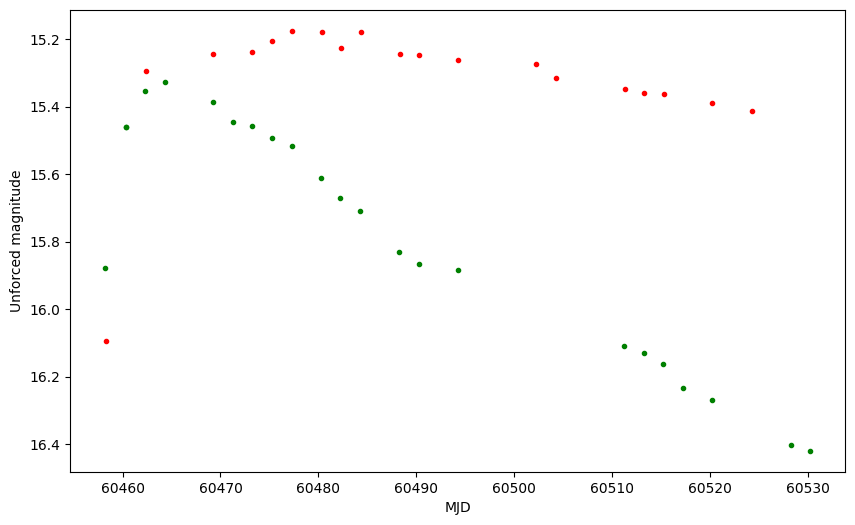

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_xlabel('MJD')
ax.set_ylabel('Unforced magnitude')

for color in filter_colors:
    lightcurve_color=lightcurve[lightcurve['filter']==color]
    plt.scatter(lightcurve_color['MJD'],lightcurve_color['unforced_mag'],marker='.',color=color)

In [6]:
torch.set_default_dtype(torch.float64)

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
            )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)   

/home/cavaglia/.local/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


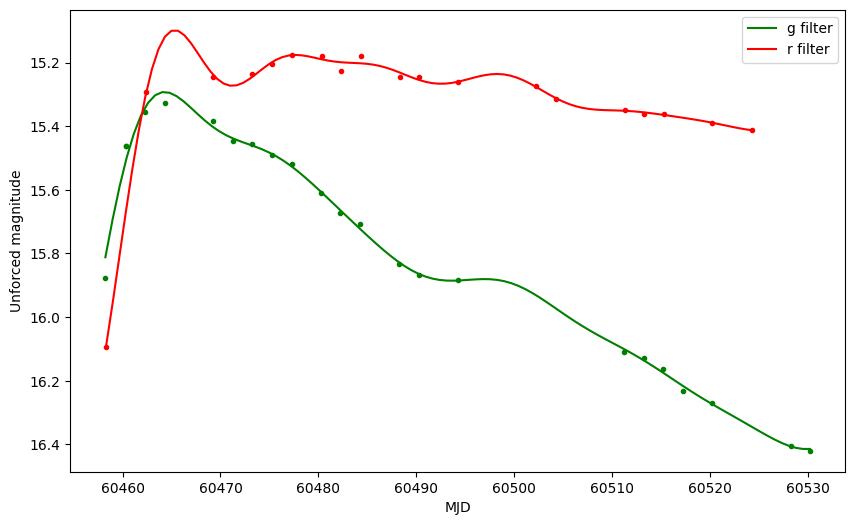

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.gca().invert_yaxis()
ax.set_xlabel('MJD')
ax.set_ylabel('Unforced magnitude')

for color in filter_colors:
    lightcurve_color=lightcurve[lightcurve['filter']==color]
    scaler = preprocessing.StandardScaler().fit(lightcurve_color['unforced_mag'].values.reshape(-1,1))
    scaled = scaler.transform(lightcurve_color['unforced_mag'].values.reshape(-1,1)).flatten()

    train_x = torch.from_numpy(lightcurve_color['MJD'].values).to(torch.float64)
    train_y = torch.from_numpy(scaled).to(torch.float64)

    X = np.linspace(lightcurve_color['MJD'].values[0],lightcurve_color['MJD'].values[-1],100)
    test_x = torch.from_numpy(X).to(torch.float64)

    likelihood = gpytorch.likelihoods.GaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    n_iter = 100
    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output,train_y).sum()
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()  

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(test_x))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

    fitted = scaler.inverse_transform(mean.numpy().reshape(-1,1)).flatten() #.reshape(len(X),-1)
    ax.plot(X,fitted,color=color,label=color+' filter')
    plt.scatter(lightcurve_color['MJD'],lightcurve_color['unforced_mag'],marker='.',color=color)
ax.legend()

In [ ]:
# print the peak time